In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv
/kaggle/input/demand-forecasting-kernels-only/train.csv
/kaggle/input/demand-forecasting-kernels-only/test.csv


# **Business understanding**

### The goal of this analysis is make a forecasting demand model for items in a store. 

# **Data understanding**

## Data fields dictionary
### - **date**: Date of the sale data. There are no holiday effects or store closures.
### - **store**: Store ID
### - **item**: Item ID
### - **sales**: Number of items sold at a particular store on a particular date.

In [2]:
import time
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv')
df_test = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/test.csv')

In [4]:
df_train.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [5]:
df_train.tail(10)

,date,store,item,sales
912990,2017-12-22,10,50,75
912991,2017-12-23,10,50,70
912992,2017-12-24,10,50,76
912993,2017-12-25,10,50,51
912994,2017-12-26,10,50,41
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [6]:
df_train.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [8]:
df_train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [9]:
df_train['store'].value_counts()

store
1     91300
2     91300
3     91300
4     91300
5     91300
6     91300
7     91300
8     91300
9     91300
10    91300
Name: count, dtype: int64

In [10]:
df_train['item'].value_counts()

item
1     18260
2     18260
3     18260
4     18260
5     18260
6     18260
7     18260
8     18260
9     18260
10    18260
11    18260
12    18260
13    18260
14    18260
15    18260
16    18260
17    18260
18    18260
19    18260
20    18260
21    18260
22    18260
23    18260
24    18260
25    18260
26    18260
27    18260
28    18260
29    18260
30    18260
31    18260
32    18260
33    18260
34    18260
35    18260
36    18260
37    18260
38    18260
39    18260
40    18260
41    18260
42    18260
43    18260
44    18260
45    18260
46    18260
47    18260
48    18260
49    18260
50    18260
Name: count, dtype: int64

In [11]:
unique_items: list = df_train['item'].unique()
print(f"There is {len(unique_items)} diferent types of items.\n")
print(f"This items are: {unique_items}")

There is 50 diferent types of items.

This items are: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


In [12]:
unique_stores: list = df_train['store'].unique()
print(f"There is {len(unique_stores)} diferent types of stores.\n")
print(f"This stores are: {unique_stores}")

There is 10 diferent types of stores.

This stores are: [ 1  2  3  4  5  6  7  8  9 10]


In [13]:
#transformando o campo de data para o tipo date (está como object)
df_train['date'] = pd.to_datetime(df_train['date']) #train
df_test['date'] = pd.to_datetime(df_test['date']) #test

In [14]:
# transformando o campo de item e store em tipo categórico

# train
df_train['item'] = df_train['item'].astype('category')
df_train['store'] = df_train['store'].astype('category')

# test
df_test['item'] = df_test['item'].astype('category')
df_test['store'] = df_test['store'].astype('category')

In [15]:
# Check the updated DataFrame
df_train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


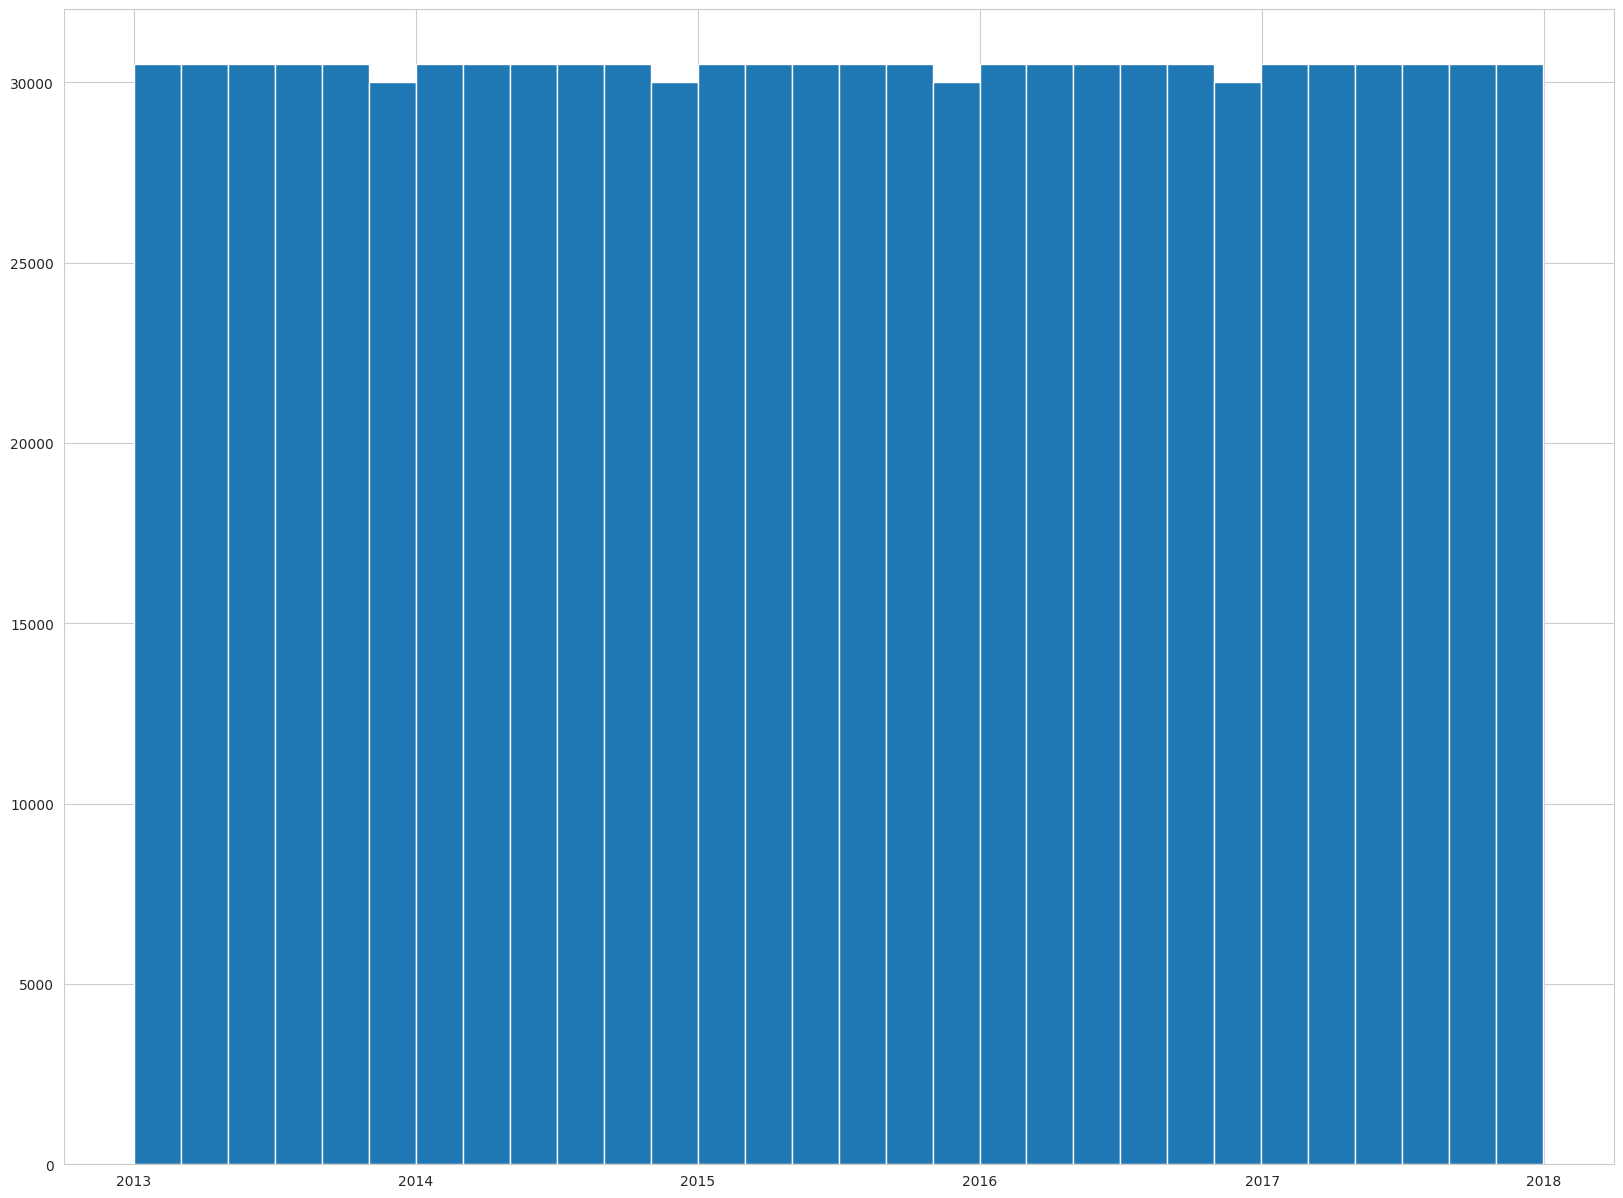

In [16]:
#Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Histogram for each feature
df_train['date'].hist(bins=30, figsize=(20, 15))
plt.show()

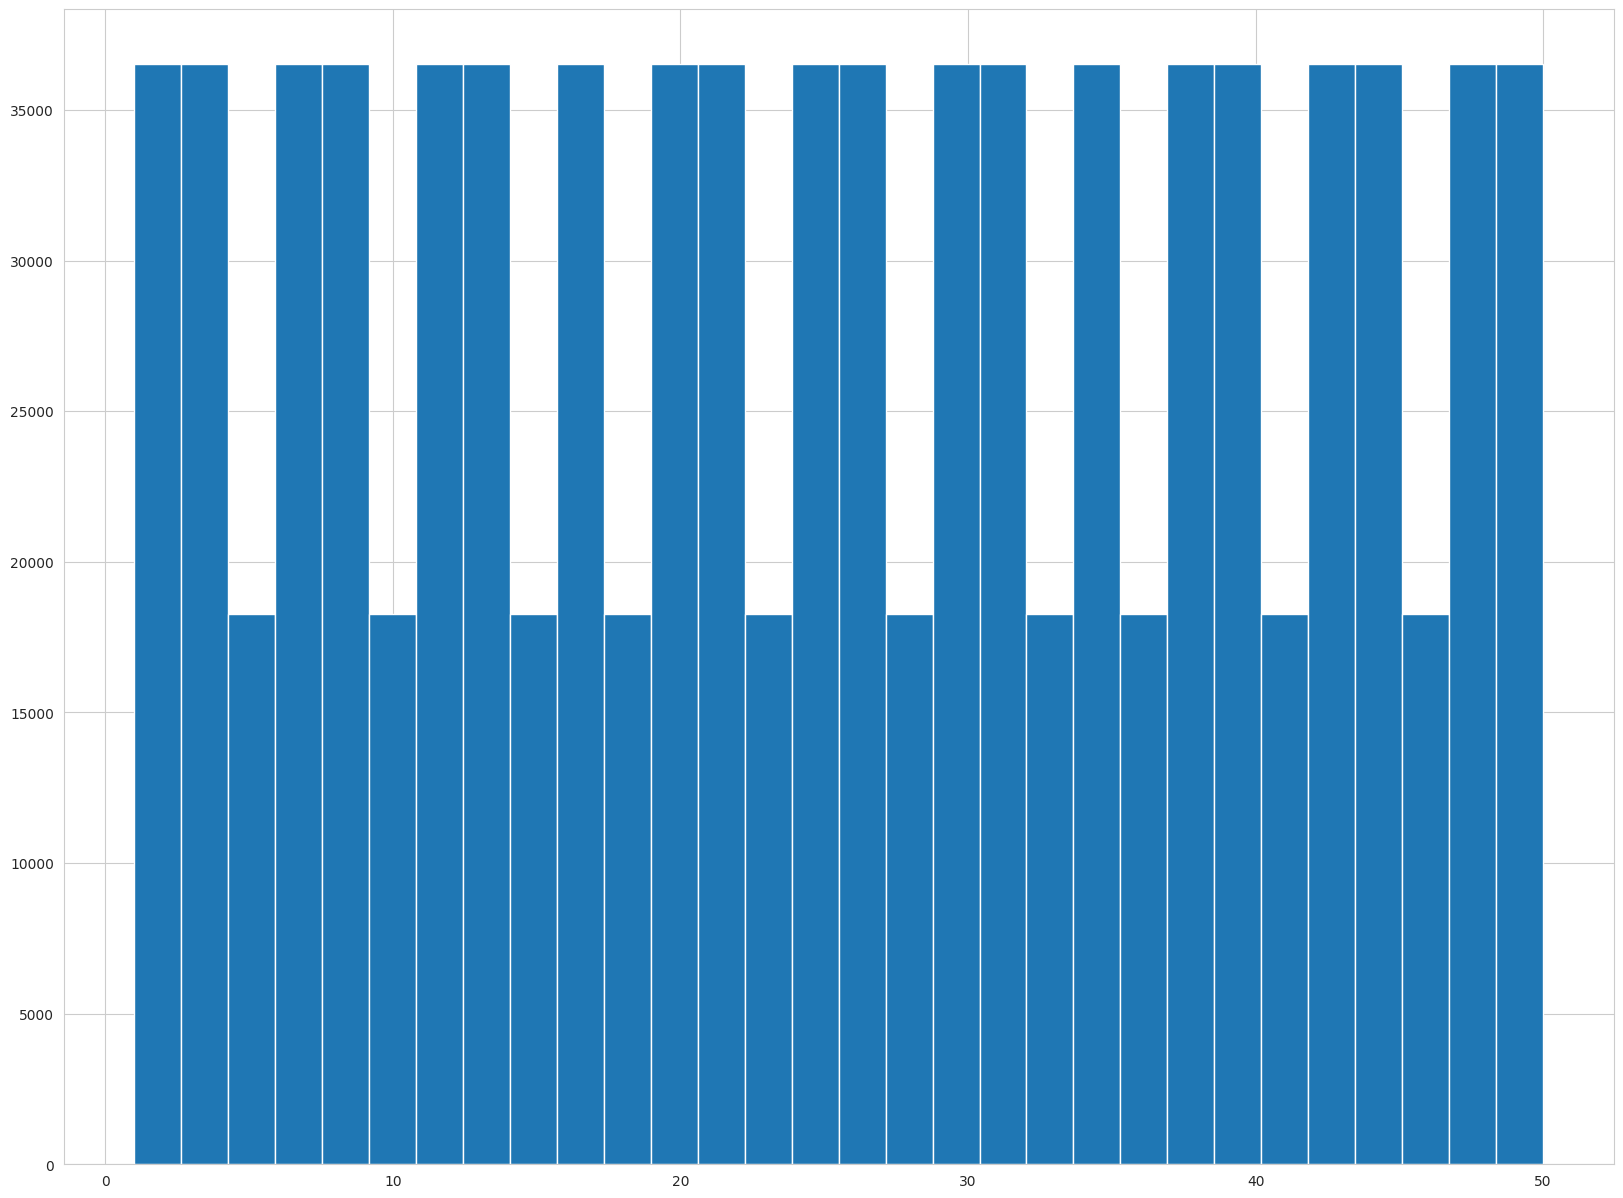

In [17]:
#Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Histogram for each feature
df_train['item'].hist(bins=30, figsize=(20, 15))
plt.show()

In [18]:
df_train.head(5)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


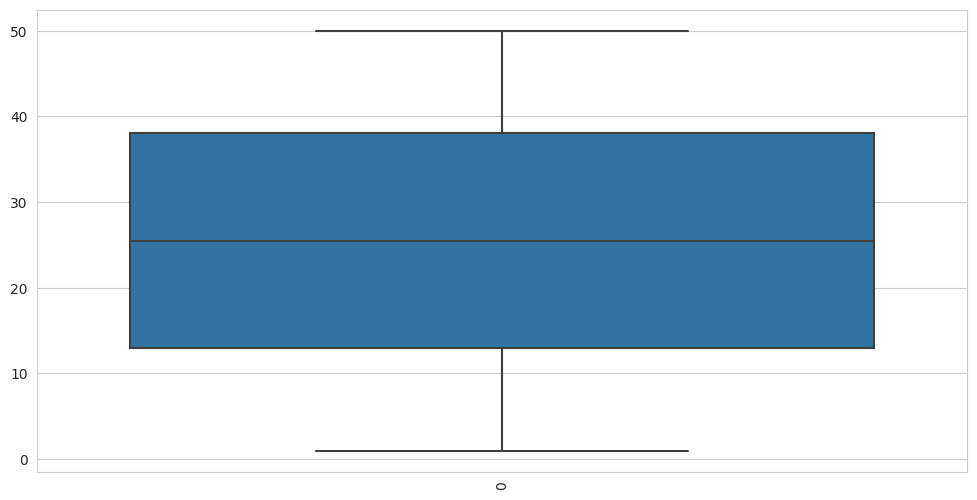

In [19]:
# Box plot for each feature
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_train['item'])
plt.xticks(rotation=90)
plt.show()

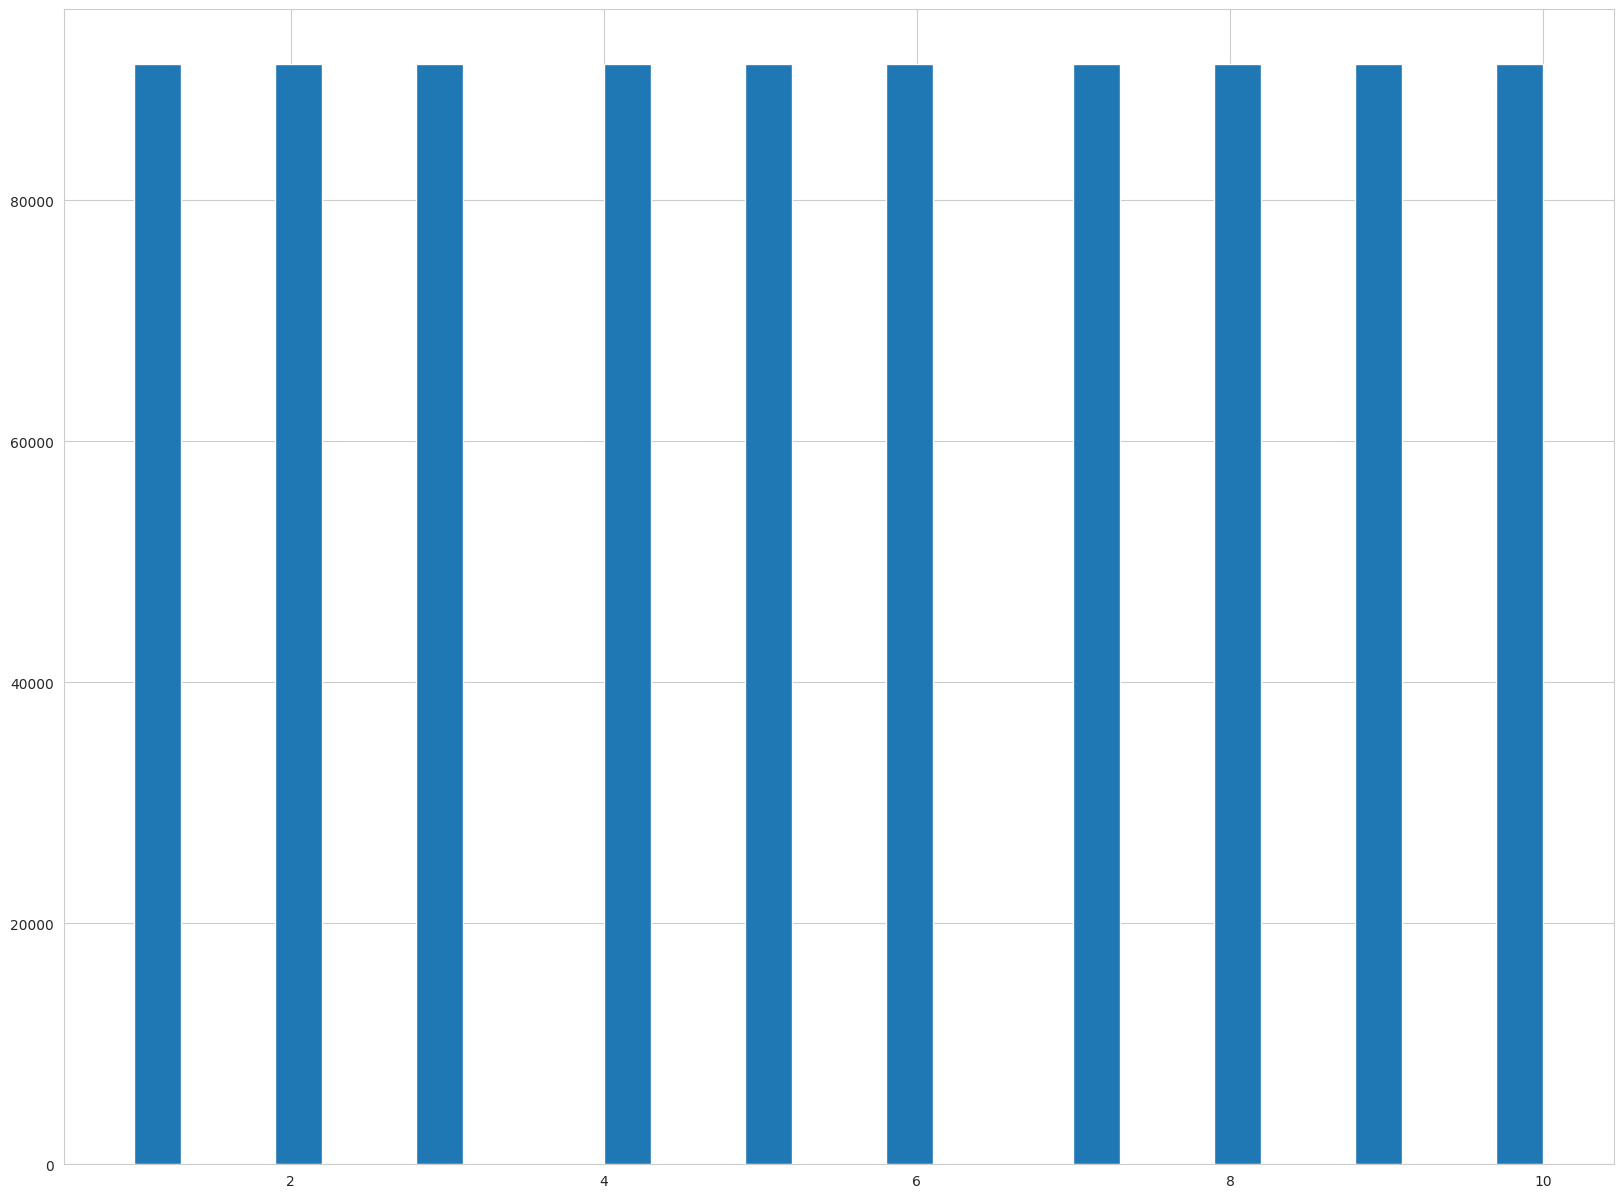

In [20]:
#Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Histogram for each feature
df_train['store'].hist(bins=30, figsize=(20, 15))
plt.show()

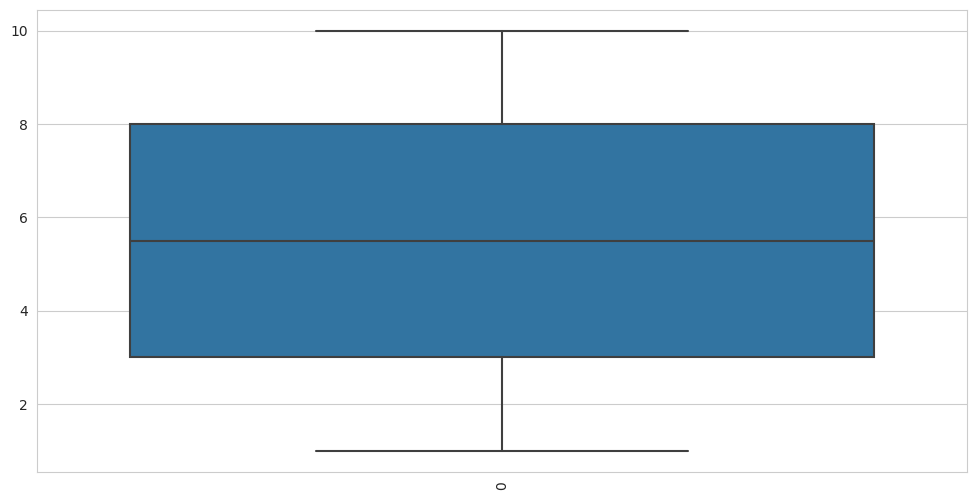

In [21]:
# Box plot for each feature
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_train['store'])
plt.xticks(rotation=90)
plt.show()

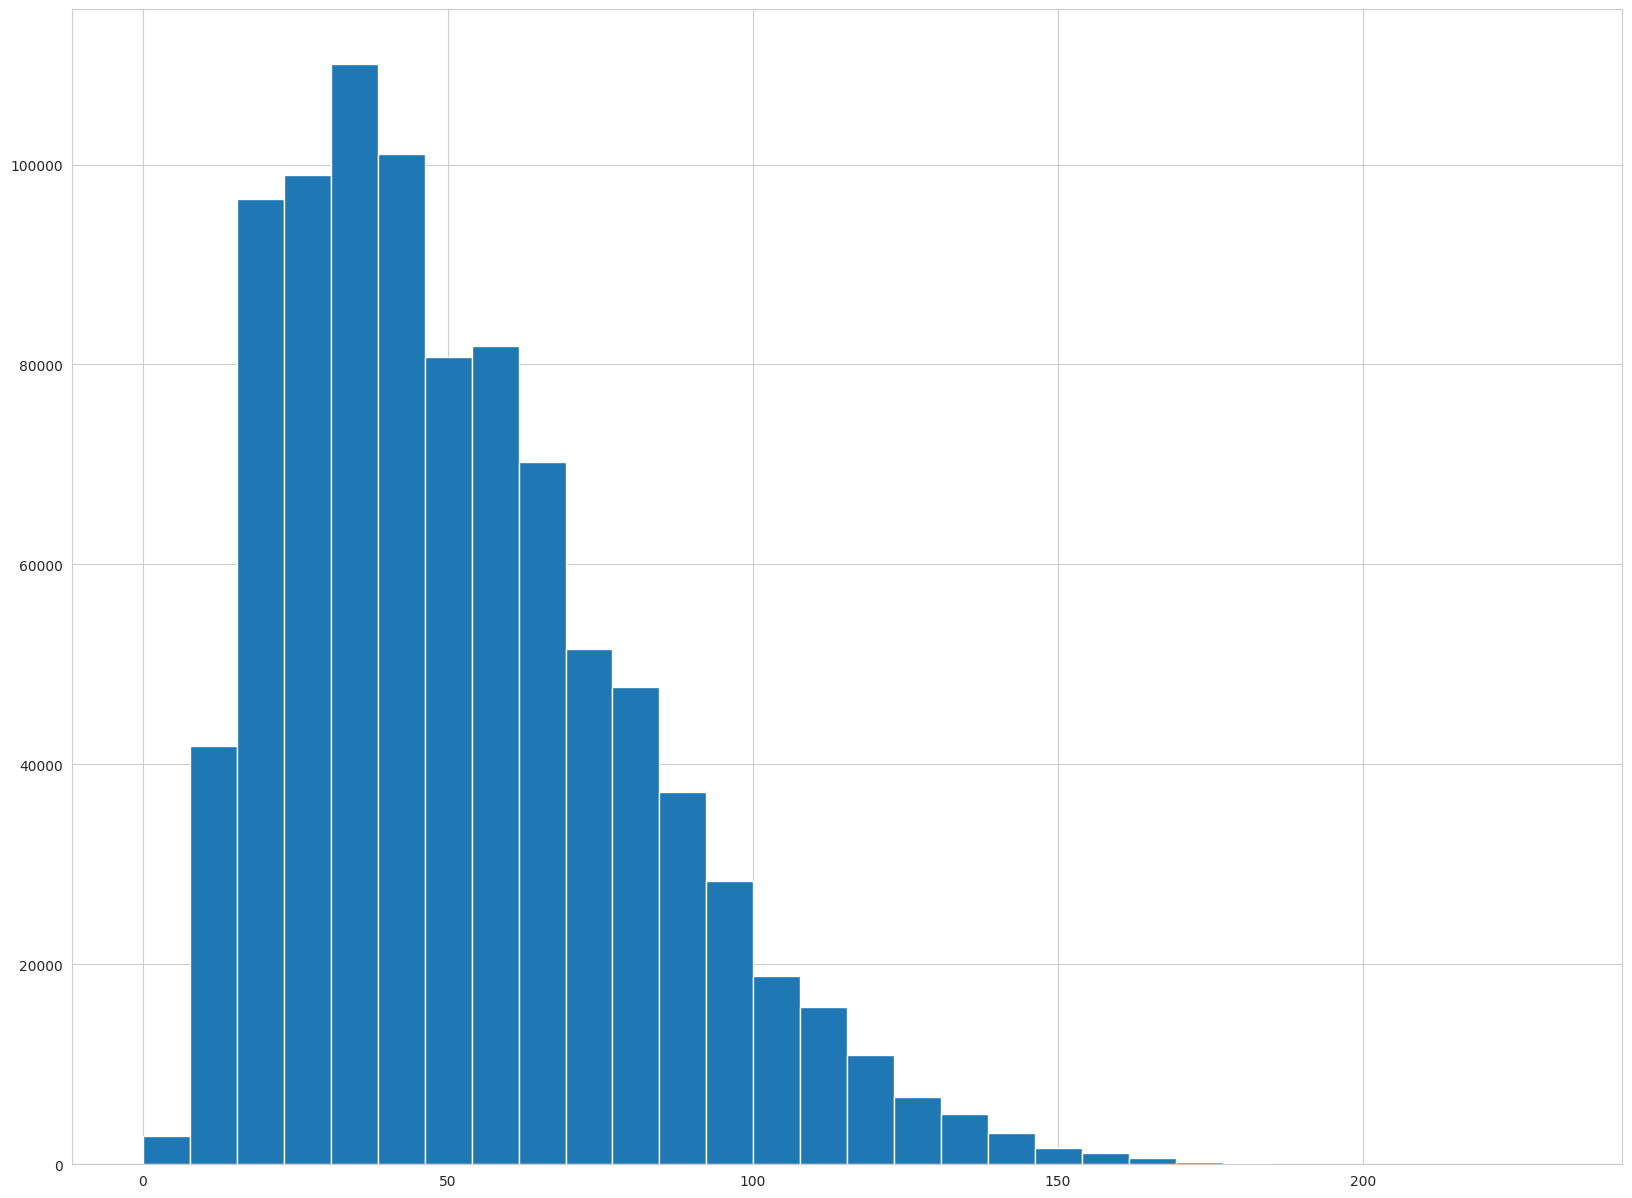

In [22]:
#Set the aesthetic style of the plots
sns.set_style('whitegrid')

# Histogram for each feature
df_train['sales'].hist(bins=30, figsize=(20, 15))
plt.show()

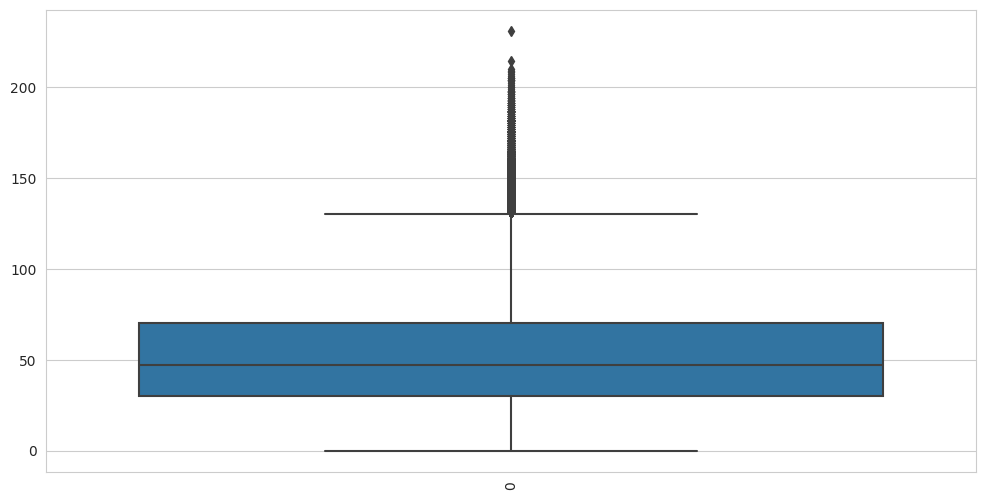

In [23]:
# Box plot for each feature
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_train['sales'])
plt.xticks(rotation=90)
plt.show()

In [24]:
# Extract train date features
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek  # Monday=0, Sunday=6
df_train['day_of_year'] = df_train['date'].dt.dayofyear
df_train['week_of_year'] = df_train['date'].dt.isocalendar().week

In [25]:
# Extrat test date features
df_test['year'] = df_test['date'].dt.year
df_test['month'] = df_test['date'].dt.month
df_test['day'] = df_test['date'].dt.day
df_test['day_of_week'] = df_test['date'].dt.dayofweek  # Monday=0, Sunday=6
df_test['day_of_year'] = df_test['date'].dt.dayofyear
df_test['week_of_year'] = df_test['date'].dt.isocalendar().week

In [26]:
# Add lagged train features
for lag in range(1, 8):
    df_train[f'sales_lag_{lag}'] = df_train['sales'].shift(lag)

# Drop rows with NaN values introduced by lagging
df_train.dropna(inplace=True)

# Check the updated DataFrame
df_train.head()

,date,store,item,sales,year,month,day,day_of_week,day_of_year,week_of_year,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7
7,2013-01-08,1,1,9,2013,1,8,1,8,2,10.0,12.0,10.0,13.0,14.0,11.0,13.0
8,2013-01-09,1,1,12,2013,1,9,2,9,2,9.0,10.0,12.0,10.0,13.0,14.0,11.0
9,2013-01-10,1,1,9,2013,1,10,3,10,2,12.0,9.0,10.0,12.0,10.0,13.0,14.0
10,2013-01-11,1,1,9,2013,1,11,4,11,2,9.0,12.0,9.0,10.0,12.0,10.0,13.0
11,2013-01-12,1,1,7,2013,1,12,5,12,2,9.0,9.0,12.0,9.0,10.0,12.0,10.0


In [27]:
# Add lagged test features
y_test = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv')

for lag in range(1, 8):
    y_test[f'sales_lag_{lag}'] = y_test['sales'].shift(lag)

# Drop rows with NaN values introduced by lagging
y_test.dropna(inplace=True)

# Check the updated DataFrame
df_test.head()

,id,date,store,item,year,month,day,day_of_week,day_of_year,week_of_year
0,0,2018-01-01,1,1,2018,1,1,0,1,1
1,1,2018-01-02,1,1,2018,1,2,1,2,1
2,2,2018-01-03,1,1,2018,1,3,2,3,1
3,3,2018-01-04,1,1,2018,1,4,3,4,1
4,4,2018-01-05,1,1,2018,1,5,4,5,1


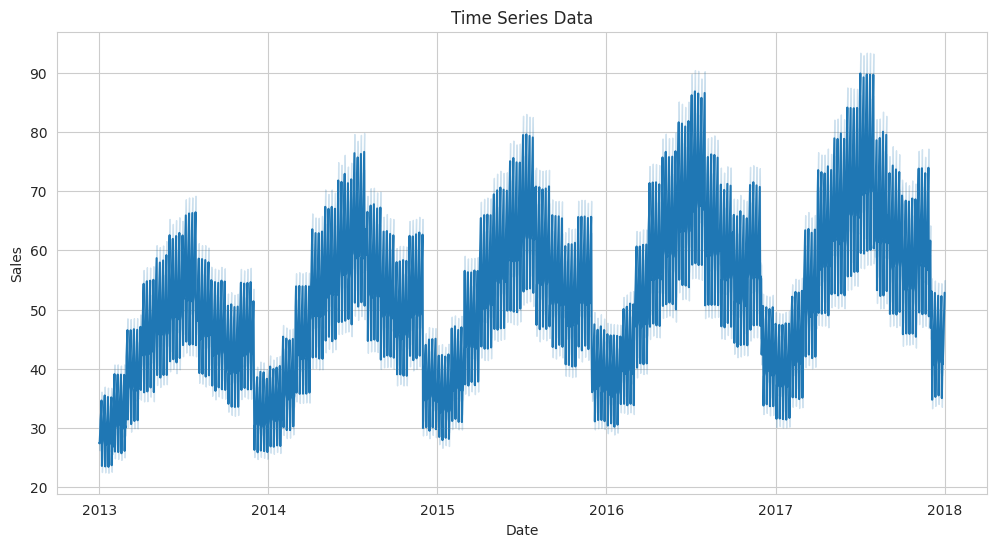

In [28]:
#Set the 'Date' column as the index
df_train_vis = df_train.copy()

df_train_vis.set_index('date', inplace=True)

# Plotting the time series
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_train_vis, x='date', y='sales')

# Adding title and labels
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Sales')

# Display the plot
plt.show()

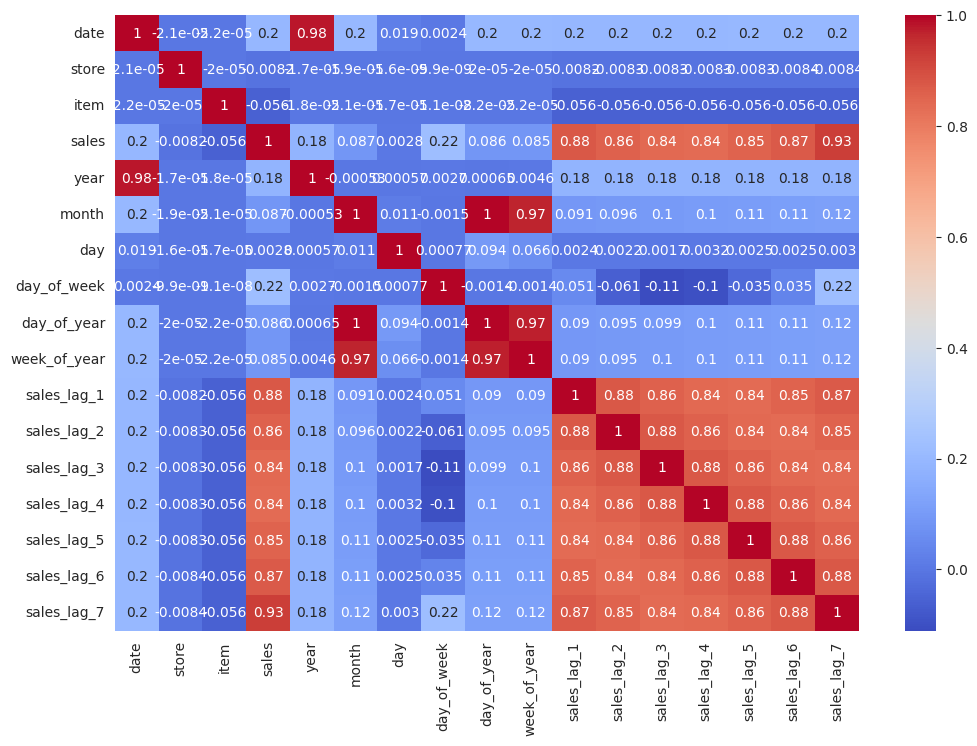

In [29]:
# Correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = df_train.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [30]:
# One-hot encoding for train categorical variables
df_train = pd.get_dummies(df_train, drop_first=True)

In [31]:
# One-hot encoding for test categorical variables
df_test = pd.get_dummies(df_test, drop_first=True)

In [32]:
# Inner join on the 'id' column
df_test = pd.merge(df_test, y_test, on='id', how='inner')

In [43]:
# Reorder the test DataFrame columns to match the train DataFrame
df_test = df_test[df_train.columns]

In [47]:
# Prepare features and target variable for training
y_test = df_test['sales'].copy(deep=True)
y_train = df_train['sales'].copy(deep=True)

X_train = df_train.drop('sales', axis=1).copy(deep=True)
X_test = df_test.drop('sales', axis=1).copy(deep=True)

X_train = X_train.drop('date', axis=1)
X_test = X_test.drop('date', axis=1)

In [51]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)
train_rmse_rf = mean_squared_error(y_train, y_pred_train_rf, squared=False)
test_rmse_rf = mean_squared_error(y_test, y_pred_test_rf, squared=False)
print(f'Random Forest Train RMSE: {train_rmse_rf}')
print(f'Random Forest Test RMSE: {test_rmse_rf}')

Random Forest Train RMSE: 3.01405600926441
Random Forest Test RMSE: 6.469301557764979


In [54]:
# Gradient Boosting Machines
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_train_gb = gb_model.predict(X_train)
y_pred_test_gb = gb_model.predict(X_test)
train_rmse_gb = mean_squared_error(y_train, y_pred_train_gb, squared=False)
test_rmse_gb = mean_squared_error(y_test, y_pred_test_gb, squared=False)
print(f'Gradient Boosting Machines Train RMSE: {train_rmse_gb}')
print(f'Gradient Boosting Machines Test RMSE: {test_rmse_gb}')

Gradient Boosting Machines Train RMSE: 8.098868446483548
Gradient Boosting Machines Test RMSE: 4.606659242742655


In [62]:
submission = pd.DataFrame()
submission['sales'] = y_pred_test_rf.copy()
submission.insert(0, 'id', range(1, len(submission) + 1))
submission

,id,sales
0,1,39.45
1,2,50.72
2,3,50.88
3,4,52.24
4,5,55.33
...,...,...
44988,44989,48.82
44989,44990,49.43
44990,44991,50.99
44991,44992,54.58


In [65]:
submission.to_csv('/kaggle/working/submissionrf.csv', index=False)